In [ ]:
# Переключатель включение/выключения подбора параметров в optuna
#
# !!! Предупреждение !!! Включение подбора параметров увеличивает
# время выполнения более чем на 30 минут
#
# OPTUNA_TRAIN = True  <- будет проводиться подбор параметров
# OPTUNA_TRAIN = False <- НЕ будет проводиться подбор параметров
OPTUNA_TRAIN = False

In [ ]:
# Подгружаем файлы утилит

!mkdir utilities

!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/notebooks/src/utils.py -O /content/utilities/utils.py
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/notebooks/src/__init__.py -O /content/utilities/__init__.py

import sys
sys.path.append('/content/utilities')

!pip install seaborn -q
!pip install catboost -q
!pip install lightgbm -q
!pip install xgboost -q
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
# Импорт библиотек

import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from scipy import stats

import lightgbm as lgb
import xgboost as xgb

import utilities.utils as utils

import warnings; warnings.filterwarnings("ignore")

----

Загрузка данных

Загрузка данных производиться прям с сервера.

Иногда бывает проблемы с сервером и он выдает отказ.

По этой причине разнёс загрузку по разным ячейкам что бы можно было перезапустить отдельно

In [ ]:
# Загрузка тренировочных данных
url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv'
train = pd.read_csv(url)

# Загрузка тестовых данных
url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv'
test = pd.read_csv(url)

# Оптимизируем данные
print('Optimization train')
train = utils.reduce_mem_usage(train)
print('Optimization test')
test = utils.reduce_mem_usage(test)

Optimization train
Memory usage of dataframe is 0.30 MB
Memory usage after optimization is: 0.15 MB
Decreased by 50.0%
Optimization test
Memory usage of dataframe is 0.23 MB
Memory usage after optimization is: 0.12 MB
Decreased by 48.4%


---
Основное исследование данных проводилось в работе:

4.4.4 Большой практический урок.

ССЫЛКА:

https://github.com/kirillovk/Introduction_to_Competitive_Data_Science/blob/main/Great_Practice_Lesson.ipynb

Для того что бы не повторяться и не загромождать Jupyter Notebook рекомендую ознакомиться по ссылке.

Цель этого Jupyter Notebook блендинг и стеккинг


In [ ]:
# Сохраненные модели
model_all = []

# Исправляем неверные значения в данных т.к. машина не может работать раньше
# чем она была произведена
tmp1 = train[(train['year_to_work'] - train['year_to_start']) < 0]['year_to_start']
tmp2 = train[(train['year_to_work'] - train['year_to_start']) < 0]['year_to_work']
train.loc[tmp1.index, 'year_to_start'] = tmp2.values
train.loc[tmp1.index, 'year_to_work'] = tmp1.values

tmp1 = test[(train['year_to_work'] - test['year_to_start']) < 0]['year_to_start']
tmp2 = test[(train['year_to_work'] - test['year_to_start']) < 0]['year_to_work']
test.loc[tmp1.index, 'year_to_start'] = tmp2.values
test.loc[tmp1.index, 'year_to_work'] = tmp1.values

# Сохраним car_id отдельно
data_dic = {'car_id' : train['car_id'], 'target_reg' : train['target_reg']}
tmp_train_sub = pd.DataFrame(data=data_dic)

# Сохраняем target_class
train_target_class = train['target_class']

# Убираем все не нужные колонки
train.drop(columns=['deviation_normal_count', 'target_class', 'car_id'], inplace = True)

data_dic = {'car_id' : test['car_id']}
tmp_test_sub = pd.DataFrame(data=data_dic)

test.drop(columns=['deviation_normal_count', 'target_class', 'car_id'], inplace = True)

# Сформируем удобные переменные которые нам пригодятся
cat_features = ['model', 'car_type', 'fuel_type']
targets = ['target_reg']

---

---
Сосредоточимся на самих моделях и поэкспериментируем с ними.

Попробуем несколько моделей и найдем самые оптимальные параметры

In [ ]:
# Разбиение данных на фолды
n_splits = 3  # Число фолдов.

# параметры валидации, обучение будет идти на n_splits фолдах
X = train.drop(columns=targets, errors='ignore')
y = train['target_reg']

# Для различных тестов
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Закодируем категориальные переменные (для тех кто не умеет работать с категориями)
# в One Hot Encode т.к. порядка в виде последовательности нет
X_CatCoded = X.copy(deep = True)
for col in cat_features:
  one_hot = pd.get_dummies(X_CatCoded[col], prefix = col)
  X_CatCoded = X_CatCoded.drop(col,axis = 1)
  X_CatCoded = X_CatCoded.join(one_hot)

test_CatCoded = test.copy(deep = True)
for col in cat_features:
  one_hot = pd.get_dummies(test_CatCoded[col], prefix = col)
  test_CatCoded = test_CatCoded.drop(col,axis = 1)
  test_CatCoded = test_CatCoded.join(one_hot)

X_train_all_CatCoded, X_test_all_CatCoded = X_CatCoded.iloc[X_train_all.index], X_CatCoded.iloc[X_test_all.index]

# Эксперементы с CatBoost

In [ ]:
# Эксперименты с CatBoost он же наш первый блендинг

# Создадим специальные объекты для обучения заранее что бы во время работы не тратить на это время.
listTrainPool = []
listTestPool = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Специальный класс для ускорения обучения
    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    listTrainPool.append(train_pool)

    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)
    listTestPool.append(test_pool)

# Объявляем функцию обучения CatBoost
def fit_catboost(trial, train_pool, test_pool):
    param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "eval_metric": "RMSE", # Тоже стоит заранее определиться
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
        "depth": trial.suggest_int("depth", 3, 9),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "used_ram_limit": "10gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)

    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = CatBoostRegressor(
        **param,
        random_seed=42, thread_count=-1, cat_features=cat_features,
        one_hot_max_size = 2.0, iterations = 4000
    )

    model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=False,
        use_best_model=True,
        plot=False,
        early_stopping_rounds=100
    )

    return model, model.best_score_['validation']['RMSE']

# Объявляем функцию для optuna
def objective_catboost(trial, return_models=False):
    scores, models = [], []
    for indexKFold in range(n_splits):
        # Подаем trials для перебора
        model, score = fit_catboost(trial, listTrainPool[indexKFold], listTestPool[indexKFold]) # Определили выше
        scores.append(score)
        models.append(model)

    # Добавим в ошибку ещё и стандартное отклонение
    # Предположительно это должно хорошо сказаться на стабильности решения
    result = np.mean(scores) + np.std(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
# Запускаем
if OPTUNA_TRAIN == True:
  study = optuna.create_study(direction="minimize")
  optuna.logging.set_verbosity(optuna.logging.WARNING)
  study.optimize(objective_catboost, n_trials=100, n_jobs = -1, show_progress_bar=True)

[I 2023-08-18 17:43:29,434] A new study created in memory with name: no-name-a2051273-e4fd-497e-b096-79e7fd5c06a1


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Выведем полученные параметры
if OPTUNA_TRAIN == True:
  print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 11.849498004849062, params {'colsample_bylevel': 0.7612131610431632, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 3, 'depth': 4, 'learning_rate': 0.002249093932707261, 'subsample': 0.568238115900688}


In [ ]:
# Зависимость в разрезе по параметрам
if OPTUNA_TRAIN == True:
  params = ['l2_leaf_reg', 'colsample_bylevel', 'bagging_temperature', 'depth', 'bootstrap_type', 'subsample']
  fig = optuna.visualization.plot_slice(study,
                                  params=params,
                                  target_name = 'RMSE')
  fig.show()

Из графика выше видно что

Наилучшие интервалы

boosting_type = Bernoulli

depth = от 3 до 5

colsample_bylevel = от 0.6 до 0.8

l2_leaf_reg = от 2 до 6

subsample = от 0.5 до 0.7


In [ ]:
# Найденные лучшие параметры для CatBoost
# Для данных параметров скор на тесте stepik.org RMSE=11.8
# Порог в 11.85 RMSE пройден
best_params_catboost = {'colsample_bylevel': 0.701278171101739,
                        'boosting_type': 'Ordered',
                        'bootstrap_type': 'Bernoulli',
                        'l2_leaf_reg': 4, 'depth': 3,
                        'learning_rate': 0.005944524701090079,
                        'subsample': 0.5233078274283042}

# Обучаем модель на лучших параметрах
if OPTUNA_TRAIN == True :
  valid_scores, models = objective_catboost( optuna.trial.FixedTrial(study.best_params),
      return_models=True
  )
else:
  valid_scores, models = objective_catboost( optuna.trial.FixedTrial(best_params_catboost),
      return_models=True
  )

model_all.append(models.copy())

# Посмотрим какая точность
valid_scores, len(models)

(11.849498004849062, 3)

# Эксперементы с LightGBM

In [ ]:
# Эксперименты с LightGBM он же наш второй блендинг

# Создадим специальные объекты для обучения заранее что бы во время работы не тратить на это время.
listTrainKfoldX = []
listTrainKfoldY = []
listTestKfoldX = []
listTestKfoldY = []

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):

    X_train, X_test = X_CatCoded.iloc[train_index], X_CatCoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Собираем данное в списки
    listTrainKfoldX.append(X_train)
    listTrainKfoldY.append(y_train)

    listTestKfoldX.append(X_test)
    listTestKfoldY.append(y_test)

# Объявляем функцию обучения LightGBM
def fit_lightgbm(trial, X_train, y_train, X_test, y_test):

    param = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["goss", "dart"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 1.00),
        "n_estimators": trial.suggest_int("n_estimators", 10, 500),
        "num_leaves": trial.suggest_int("num_leaves", 3, 200),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.00, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.00, 2.0),
        "max_depth": trial.suggest_int("max_depth", 3, 20000),
    }

    model = lgb.LGBMRegressor(**param, random_state = 42, n_jobs = -1)

    model.fit(
      X_train, y_train,
      eval_set=[ (X_test, y_test),],
      eval_metric = 'rmse',
      callbacks = [lgb.early_stopping(stopping_rounds=10, verbose=False)]
      )

    return model, model.best_score_['valid_0']['rmse']

# Объявляем функцию для optuna
def objective_lightgbm(trial, return_models=False):
    scores, models = [], []
    for indexKFold in range(n_splits):
        # Подаем trials для перебора
        model, score = fit_lightgbm(trial, listTrainKfoldX[indexKFold], listTrainKfoldY[indexKFold], listTestKfoldX[indexKFold], listTestKfoldY[indexKFold]) # Определили выше
        scores.append(score)
        models.append(model)

    # Добавим в ошибку ещё и стандартное отклонение
    # Предположительно это должно хорошо сказаться на стабильности решения
    result = np.mean(scores) + np.std(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
# Запускаем
if OPTUNA_TRAIN == True:
  study = optuna.create_study(direction="minimize")
  optuna.logging.set_verbosity(optuna.logging.WARNING)
  study.optimize(objective_lightgbm, n_trials=1000, n_jobs = -1, show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Зависимость в разрезе по параметрам
if OPTUNA_TRAIN == True:
  params = ['learning_rate', 'n_estimators', 'num_leaves', 'reg_alpha', 'reg_alpha', 'reg_lambda', "max_depth"]
  fig = optuna.visualization.plot_slice(study,
                                  params=params,
                                  target_name = 'RMSE')
  fig.show()

In [ ]:
# Выведем полученные параметры
if OPTUNA_TRAIN == True:
  print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 11.924686226302876, params {'boosting_type': 'dart', 'learning_rate': 0.22639044746965353, 'n_estimators': 466, 'num_leaves': 3, 'reg_alpha': 0.2823181440827913, 'reg_lambda': 0.7531399116068025, 'max_depth': 19709}


In [ ]:
# Найденные лучшие параметры для LightGBM
# Для данных параметров скор на тесте stepik.org RMSE=11.8
# Порог в 11.85 RMSE пройден
best_params_lightgbm = {'boosting_type': 'dart',
                        'learning_rate': 0.2930637222042571,
                        'n_estimators': 405,
                        'num_leaves': 3,
                        'reg_alpha': 0.9182789153793393,
                        'reg_lambda': 1.1221287598893495,
                        'max_depth': 16509}

# Обучаем модель на лучших параметрах
if OPTUNA_TRAIN == True :
  valid_scores, models = objective_lightgbm( optuna.trial.FixedTrial(study.best_params),
      return_models=True
  )
else:
  valid_scores, models = objective_lightgbm( optuna.trial.FixedTrial(best_params_lightgbm),
      return_models=True
  )

model_all.append(models.copy())

# Посмотрим какая точность
valid_scores, len(models)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1591
[LightGBM] [Info] Number of data points in the train set: 1558, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 45.021843
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1591
[LightGBM] [Info] Number of data points in the train set: 1558, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 

(11.924686226302876, 3)

# Эксперементы с XGBoost

In [ ]:
# Эксперименты с XGBoost он же наш второй блендинг

# Создадим специальные объекты для обучения заранее что бы во время работы не тратить на это время.
listTrainKfoldX = []
listTrainKfoldY = []
listTestKfoldX = []
listTestKfoldY = []

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):

    X_train, X_test = X_CatCoded.iloc[train_index], X_CatCoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Собираем данные в списки
    listTrainKfoldX.append(X_train)
    listTrainKfoldY.append(y_train)

    listTestKfoldX.append(X_test)
    listTestKfoldY.append(y_test)

# Объявляем функцию обучения XGBoost
def fit_xgboost(trial, X_train, y_train, X_test, y_test):

    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "max_depth": trial.suggest_int("max_depth", 3, 200),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.0, 10.0),
        "n_estimators": trial.suggest_int("n_estimators", 3, 200),
        "max_leaves": trial.suggest_int("max_leaves", 1, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1.0),
        "max_delta_step": trial.suggest_float("max_delta_step", 0.001, 10.0),
        "subsample": trial.suggest_float("subsample", 0.001, 0.999),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.001, 0.999),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.001, 0.999),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.001, 0.999),
    }

    model = xgb.XGBRegressor(**param, random_state = 42, n_jobs = -1)

    model.fit(
      X_train, y_train,
      eval_set=[ (X_test, y_test),],
      eval_metric = 'rmse',
      early_stopping_rounds = 10,
      verbose = False
      )

    return model, model.best_score

# Объявляем функцию для optuna
def objective_xgboost(trial, return_models=False):
    scores, models = [], []
    for indexKFold in range(n_splits):
        # Подаем trials для перебора
        model, score = fit_xgboost(trial, listTrainKfoldX[indexKFold], listTrainKfoldY[indexKFold], listTestKfoldX[indexKFold], listTestKfoldY[indexKFold]) # Определили выше
        scores.append(score)
        models.append(model)

    # Добавим в ошибку ещё и стандартное отклонение
    # Предположительно это должно хорошо сказаться на стабильности решения
    result = np.mean(scores) + np.std(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
# Запускаем
if OPTUNA_TRAIN == True:
  study = optuna.create_study(direction="minimize")
  optuna.logging.set_verbosity(optuna.logging.WARNING)
  study.optimize(objective_xgboost, n_trials=1000, n_jobs = -1, show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Зависимость в разрезе по параметрам
if OPTUNA_TRAIN == True:
  params = ['booster', 'gamma', 'reg_alpha', 'reg_lambda', "max_depth", "min_child_weight",
            "n_estimators", "max_leaves", "learning_rate", "max_delta_step", "subsample",
            "colsample_bytree", "colsample_bylevel", "colsample_bynode"]
  fig = optuna.visualization.plot_slice(study,
                                  params=params,
                                  target_name = 'RMSE')
  fig.show()

In [ ]:
if OPTUNA_TRAIN == True:
  print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 11.897033007486232, params {'booster': 'dart', 'gamma': 0.308822516345615, 'reg_alpha': 3.4302014646894103, 'reg_lambda': 8.395352827585251, 'max_depth': 3, 'min_child_weight': 9.014146114770991, 'n_estimators': 174, 'max_leaves': 88, 'learning_rate': 0.1223745456712608, 'max_delta_step': 8.052427015224671, 'subsample': 0.8422954051329563, 'colsample_bytree': 0.7997690933861559, 'colsample_bylevel': 0.7003045316199394, 'colsample_bynode': 0.8288867034670422}


In [ ]:
# Найденные лучшие параметры для XGBoost
# Для данных параметров скор на тесте stepik.org RMSE=11.8
# Порог в 11.85 RMSE пройден
best_params_xgboost = {'booster': 'gbtree',
                       'gamma': 9.197755091159614,
                       'reg_alpha': 2.8757230816880495,
                       'reg_lambda': 9.975214545086589,
                       'max_depth': 3,
                       'min_child_weight': 5.89949810352528,
                       'n_estimators': 136, 'max_leaves': 17,
                       'learning_rate': 0.2022391927943797,
                       'max_delta_step': 9.828889899365508,
                       'subsample': 0.7299564561126712,
                       'colsample_bytree': 0.9830285032143429,
                       'colsample_bylevel': 0.9230979741817792,
                       'colsample_bynode': 0.9068128501135653}

# Обучаем модель на лучших параметрах
if OPTUNA_TRAIN == True :
  valid_scores, models = objective_xgboost( optuna.trial.FixedTrial(study.best_params),
      return_models=True
  )
else:
  valid_scores, models = objective_xgboost( optuna.trial.FixedTrial(best_params_xgboost),
      return_models=True
  )

model_all.append(models.copy())

# Посмотрим какая точность
valid_scores, len(models)

(11.897033007486232, 3)

In [ ]:
# Посчитаем итоговые точности по моделям
all_rmse = []
tmp_df = pd.DataFrame()
train_list = [X, X_CatCoded, X_CatCoded]

for numberGroup, singleGroupModel in enumerate(model_all):
  for numberModel, singleModel in enumerate(singleGroupModel):
    tmp_df[f'model_group_{numberGroup}_model_{numberModel}'] = singleModel.predict(train_list[numberGroup])
    rmse_singlemodel = mean_squared_error(y, tmp_df[f'model_group_{numberGroup}_model_{numberModel}'], squared=False)
    all_rmse.append(rmse_singlemodel)
    print(f'RMSE model_group_{numberGroup}_model_{numberModel} = {rmse_singlemodel}')

RMSE model_group_0_model_0 = 11.218531991780258
RMSE model_group_0_model_1 = 11.195921017442222
RMSE model_group_0_model_2 = 11.34512442805996
RMSE model_group_1_model_0 = 11.001482253761603
RMSE model_group_1_model_1 = 11.065934676987167
RMSE model_group_1_model_2 = 11.077811149386319
RMSE model_group_2_model_0 = 10.776689529418945
RMSE model_group_2_model_1 = 10.987479209899902
RMSE model_group_2_model_2 = 10.96764087677002


In [ ]:
# Из полученных точностей получаем коэффициенты для линейной регрессии
# линейная регрессия и будет итоговой моделью стекинга
all_rmse_df = pd.DataFrame()
all_rmse_df['model_error'] = all_rmse

coeff_stack = (1 - all_rmse_df['model_error'] / all_rmse_df['model_error'].apply('sum'))/(1 - all_rmse_df['model_error'] / all_rmse_df['model_error'].apply('sum')).apply('sum')
coeff_stack

0    0.110926
1    0.110954
2    0.110767
3    0.111198
4    0.111117
5    0.111102
6    0.111480
7    0.111216
8    0.111240
Name: model_error, dtype: float64

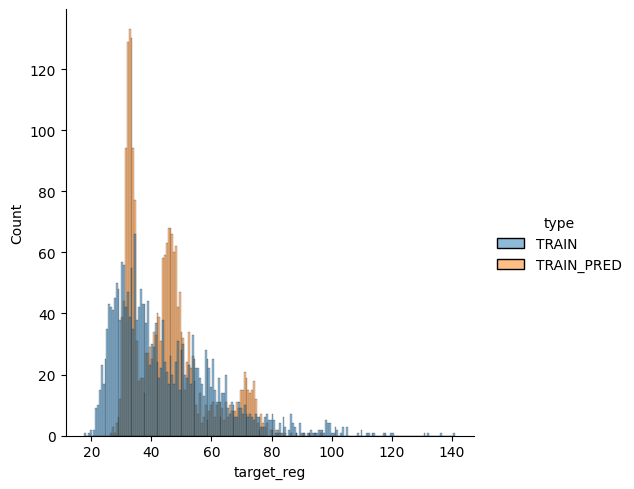

In [ ]:
# Делаем прогнозирование для тренировочных данных для анализа ошибки модели
tmp_df = pd.DataFrame()
train_list = [X, X_CatCoded, X_CatCoded]

for numberGroup, singleGroupModel in enumerate(model_all):
  for numberModel, singleModel in enumerate(singleGroupModel):
    tmp_df[f'model_group_{numberGroup}_model_{numberModel}'] = singleModel.predict(train_list[numberGroup]) * (coeff_stack[(numberGroup * 3) + numberModel])

tmp_df['target_reg'] = tmp_df.apply('sum', axis=1)

# Построим гистограмму для тренировочных данных и нашего прогноза
tmp_df_1 = y.to_frame(name = 'target_reg')
tmp_df_1['type'] = 'TRAIN'
tmp_df_2 = tmp_df['target_reg'].to_frame(name = 'target_reg')
tmp_df_2['type'] = 'TRAIN_PRED'
tmp_df_3 = pd.concat([tmp_df_1, tmp_df_2])
g = sns.displot(
  data=tmp_df_3,
  x='target_reg',
  hue="type",
  legend=True,
  aspect=1,
  kind="hist",
  alpha=0.5,
  bins= 200
);

Из гистограммы видно что распределение данных от модели отличается тремя пиками которые сильно отличаются от исходных данных. Исходные данные имеют более плавный спад. Для оценки дальнейших возможностей построим гистограмму ошибки

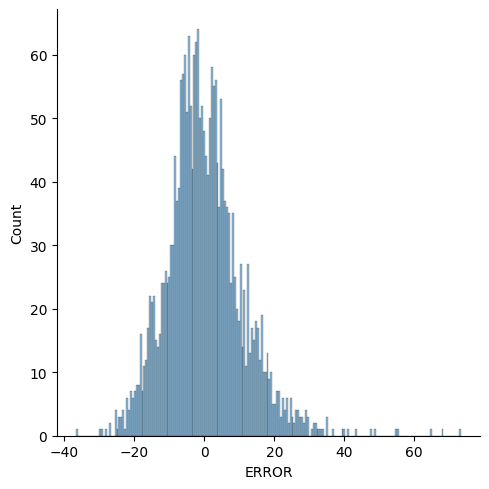

In [ ]:
# Построим гистограмму ошибки
tmpPlotDF = pd.DataFrame()
tmpPlotDF['ERROR'] = y - tmp_df['target_reg']
g = sns.displot(
  data=tmpPlotDF,
  x='ERROR',
  legend=True,
  aspect=1,
  kind="hist",
  alpha=0.5,
  bins= 200
);

Гистограмма ошибки имеет колокообразную форму и очень похоже на нормальное распределение. Исходя из этого можно сказать что из имеющихся данных и получившейся модели получен максимум. Дальнейшее улучшение точности лежит в области создание новых признаков или добавление дополнительной информации с целью уменьшение дисперсии ошибки.

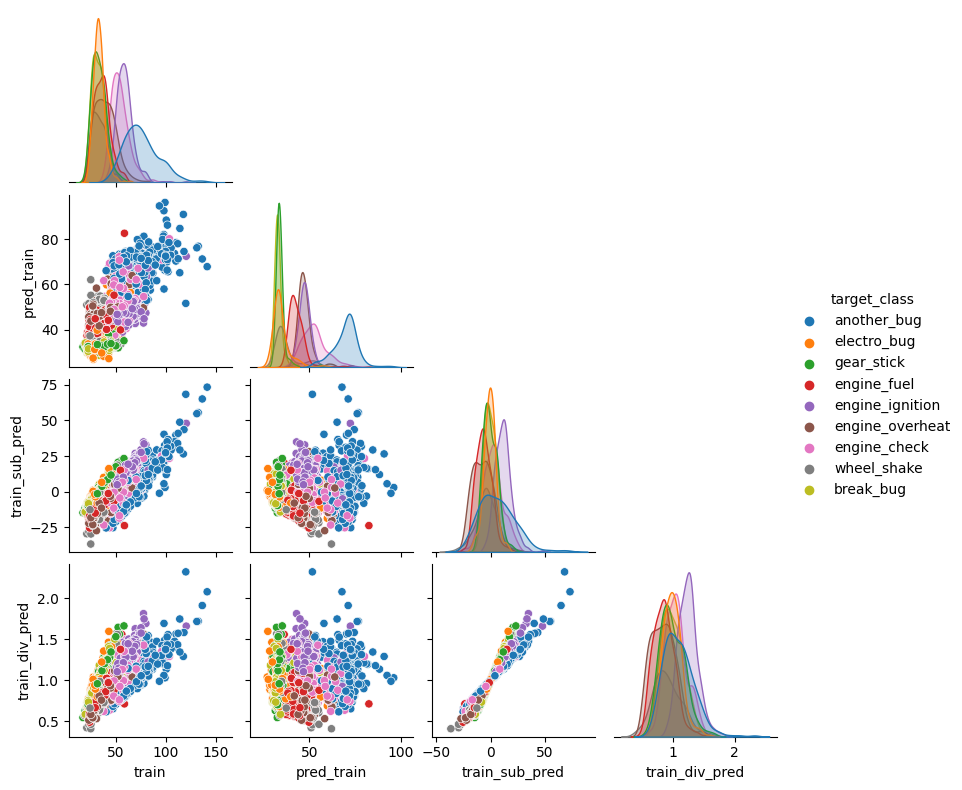

In [ ]:
# Построим график по парного распределения исходных данных и прогнозируемых и ошибки

plt_data_df = pd.DataFrame()

plt_data_df['pred_train'] = tmp_df['target_reg']
plt_data_df['train'] = y
plt_data_df['target_class'] = train_target_class
plt_data_df['train_sub_pred'] = plt_data_df['train'] - plt_data_df['pred_train']
plt_data_df['train_div_pred'] = plt_data_df['train'] / plt_data_df['pred_train']

plt_data_df = pd.concat([plt_data_df, train], axis=1)

sns.pairplot(
    plt_data_df,
    vars=["train", "pred_train", "train_sub_pred", "train_div_pred"],
    corner = True,
    hue="target_class",
    height = 2
);

Из графика выше видно что класс "engine_ignation" находиться в стороне от центрального распределения, потенциально добавив информацию о данном классе в модель можно будет увеличить точность прогнозирования.

In [ ]:
# Сделаем итоговый прогноз на тестовых данных
tmp_df = pd.DataFrame()
train_list = [test, test_CatCoded, test_CatCoded]

for numberGroup, singleGroupModel in enumerate(model_all):
  for numberModel, singleModel in enumerate(singleGroupModel):
    tmp_df[f'model_group_{numberGroup}_model_{numberModel}'] = singleModel.predict(train_list[numberGroup]) * (coeff_stack[(numberGroup * 3) + numberModel])

tmp_test_sub['target_reg'] = tmp_df.apply('sum', axis=1)

In [ ]:
# Сохраняем в файл
tmp_test_sub[['car_id', 'target_reg']].to_csv('submission.csv', index=False)
print('CSV file saved!')

CSV file saved!
